In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd
from IPython import display

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-04-14 
Git hash: d016341af9f7e0bf172fb8dbe9e83813da94ce03


In [2]:
# Notebook specific imports
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from pymongo import MongoClient

In [3]:
!ls ../../output/prealignment/agg

pe_atropos.tsv
se_atropos_libsize.tsv
se_atropos.tsv
se_bamStat.tsv
se_bamtools_stats.tsv
se_fastqc_adapter_content.tsv
se_fastqc_basic_stats.tsv
se_fastqc_kmer_content.tsv
se_fastq_clean_libsize.tsv
se_fastqc_overrepresented_seq.tsv
se_fastqc_per_base_n_content.tsv
se_fastqc_per_base_seq_content.tsv
se_fastqc_per_base_seq_quality.tsv
se_fastqc_per_seq_gc_content.tsv
se_fastqc_per_seq_quality.tsv
se_fastqc_seq_dup_level.tsv
se_fastqc_sequence_length.tsv
se_fastq_screen.tsv
se_feature_counts_summary_first.tsv
se_feature_counts_summary_second.tsv
se_hisat2.tsv
se_inferExperiment.tsv
se_md5.tsv
se_picard_collectrnaseqmetrics_first_hist.tsv
se_picard_collectrnaseqmetrics_first_summary.tsv
se_picard_markduplicates.tsv
se_samtools_idxstats.tsv
se_samtools_stats.tsv


In [4]:
# Connect to DB
client = MongoClient(host='128.231.83.74', port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [5]:
# Make a list of SRRs that were annotated in SRA as being RNASeq or Transcriptomic
agg = ncbi.aggregate([
    {'$match': {'sra.db_flags': 'RNASeq'}},
    {'$unwind': '$sra.run'},
    {'$project': {'_id': '$sra.run.run_id'}},
])

anno_rnaseq = [x['_id'] for x in agg]
len(anno_rnaseq)

18176

## Stranded

In [6]:
# Import infer_experiment data
infer = pd.read_table('../../output/prealignment/agg/se_inferExperiment.tsv', index_col=0)

# Make sure evertyhing is there
assert infer.shape[0] == 22740

# Make sure the columns are in the right order and rename
assert infer.columns.tolist() == ['Fraction of reads failed to determine',
                                  'Fraction of reads explained by "++,--"',
                                  'Fraction of reads explained by "+-,-+"']

infer.columns = ['Undetermined', 'Same Strand', 'Opposite Strand']

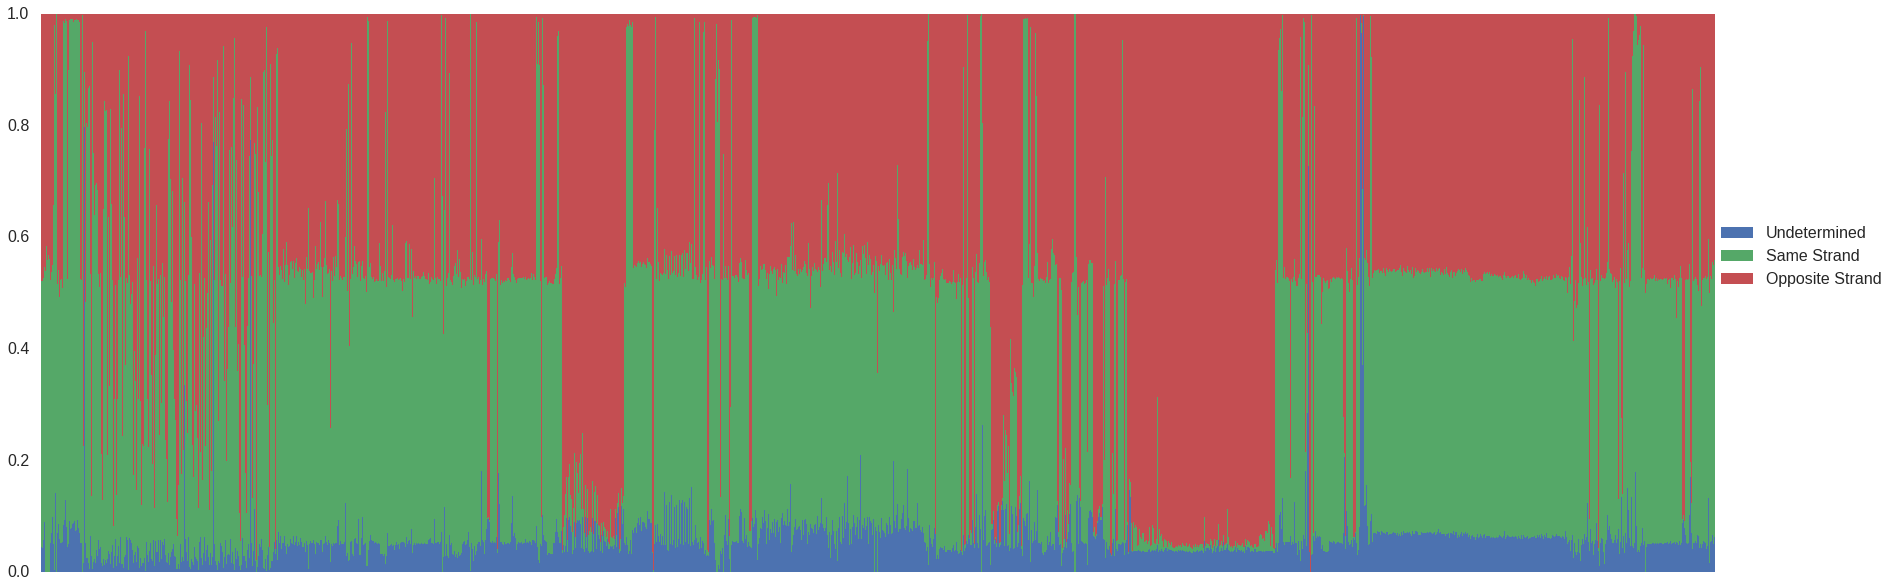

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
infer.sort_index().plot.bar(ylim=(0, 1), stacked=True, legend=False, width=1.0, ax=ax, linewidth=0)
ax.legend(loc=(1, .5))
ax.set_xticklabels([]);

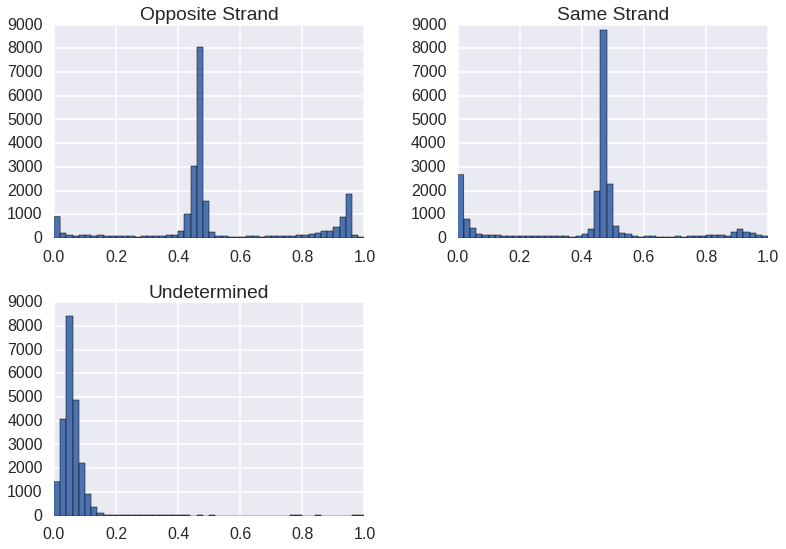

In [8]:
infer.hist(bins=50);

In [9]:
# number stranded
num_ss = sum(infer['Same Strand'] > .8)
num_os = sum(infer['Opposite Strand'] > .8)
num_ns = sum(
    (infer['Same Strand'] < 0.8) &  (infer['Opposite Strand'] < 0.8)
)

print('''\
Number Well Stranded Runs:
\tsame strand:\t\t{num_ss:,}
\topposite strand:\t{num_os:,}

Number Non Stranded runs:\t{num_ns:,}'''.format(num_ss=num_ss, num_os=num_os, num_ns=num_ns))

Number Well Stranded Runs:
	same strand:		1,791
	opposite strand:	4,472

Number Non Stranded runs:	16,468


In [10]:
# grab mieg golden to do a quick check
with open('../../data/312_sample_golden_set_2016-06-14.txt', 'r') as fh:
    mieg = [x.strip() for x in fh.readlines()]

mieg_se = [x['_id'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.srr': {'$exists': 1}},
                {'runs.srr': {'$in': mieg}},
                {'runs.pre_aln_flags': 'SE'},
            ]
        }
    },
    {'$project': {'_id': '$runs.srr'}}
])]

mieg_pe = [x['_id'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.srr': {'$exists': 1}},
                {'runs.srr': {'$in': mieg}},
                {'runs.pre_aln_flags': 'PE'},
            ]
        }
    },
    {'$project': {'_id': '$runs.srr'}}
])]

len(mieg_se), len(mieg_pe)

(146, 166)

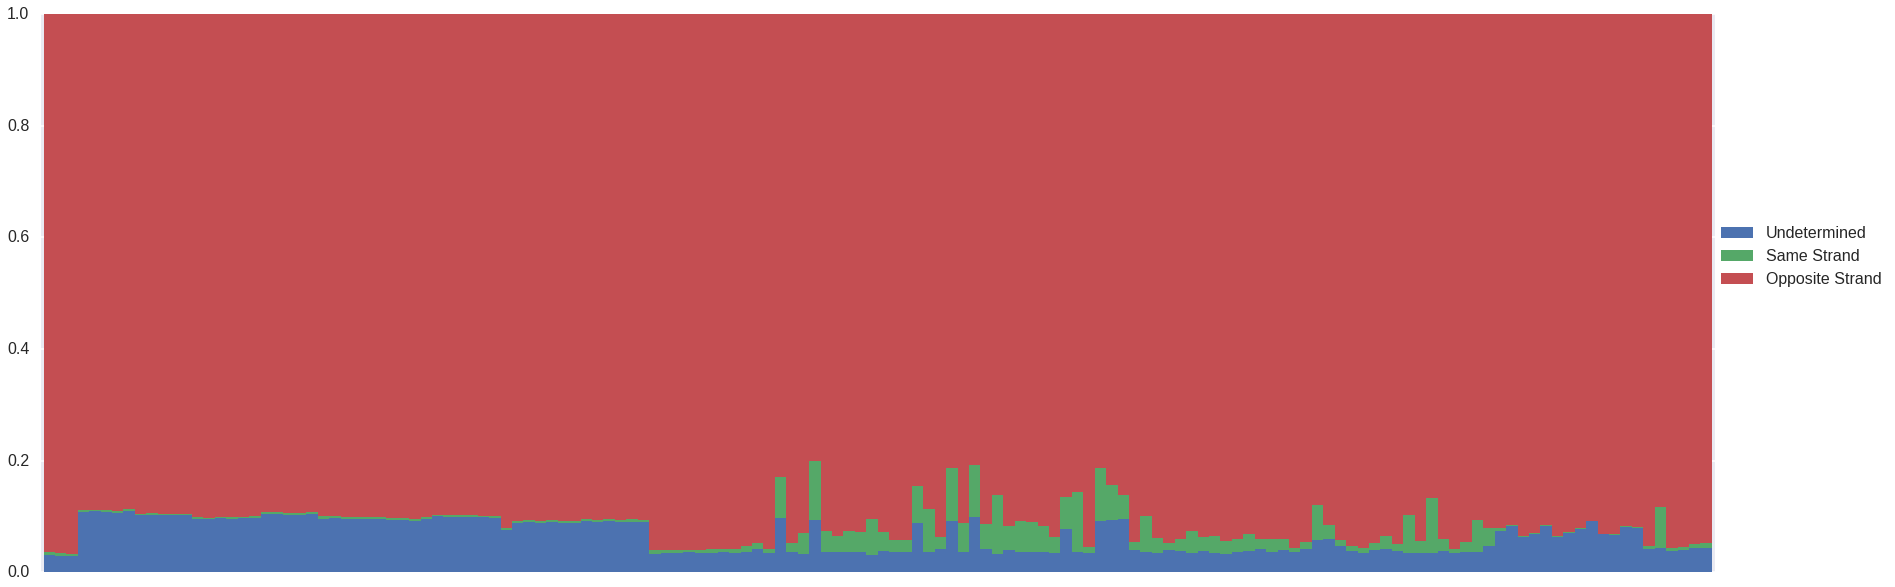

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
infer[infer.index.isin(mieg_se)].sort_index().plot.bar(ylim=(0, 1), stacked=True, legend=False, width=1.0, ax=ax, linewidth=0)
ax.legend(loc=(1, .5))
ax.set_xticklabels([]);

In [14]:
# Look at modEncode samples
with open('../../data/modEncode_srrs.txt') as fh:
    modEncode = [x.strip() for x in fh.readlines()]

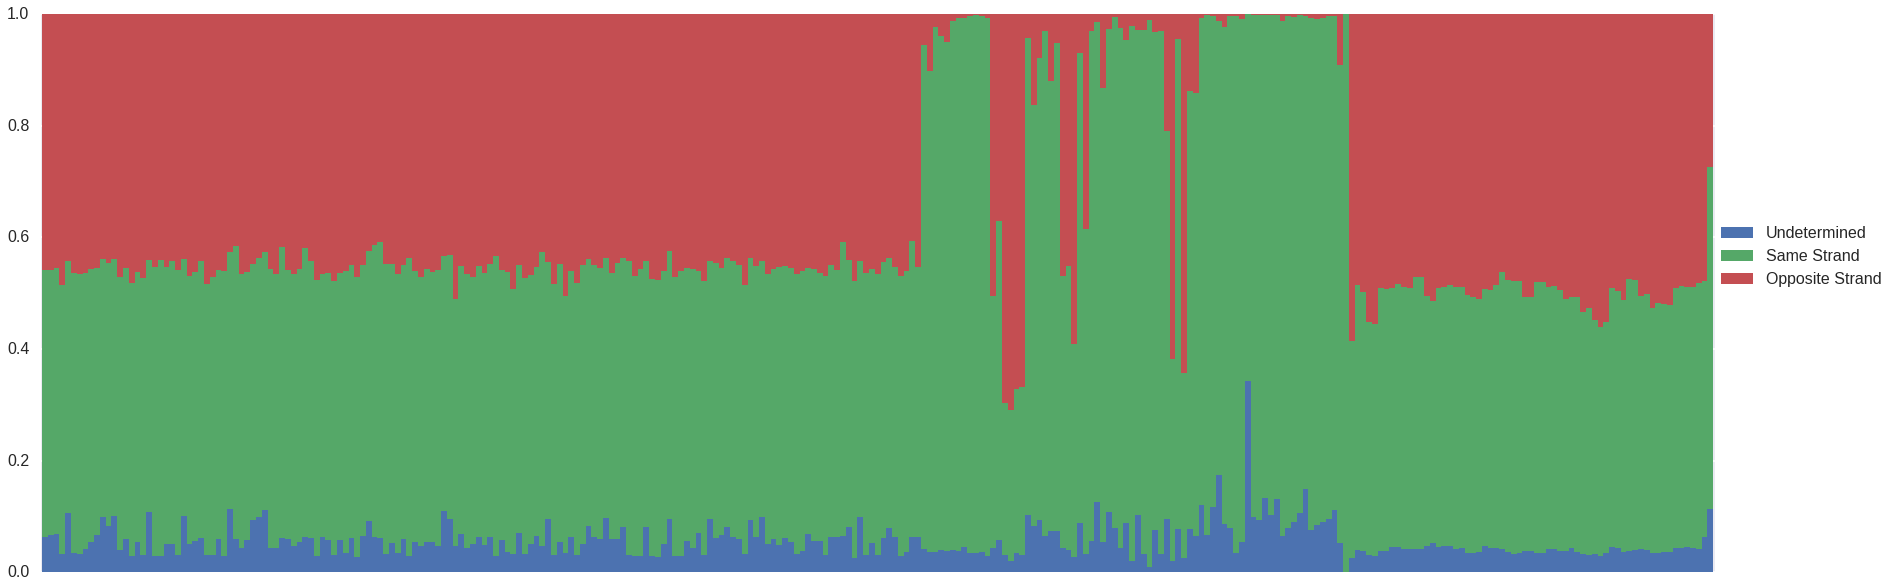

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
infer[infer.index.isin(modEncode)].sort_index().plot.bar(ylim=(0, 1), stacked=True, legend=False, width=1.0, ax=ax, linewidth=0)
ax.legend(loc=(1, .5))
ax.set_xticklabels([]);

## Gene Body Coverage

In [6]:
gb_cov = pd.read_table('../../output/prealignment/agg/se_picard_collectrnaseqmetrics_first_hist.tsv', index_col=0)

In [7]:
# Clusters samples using gene body coverage
row_linkage = linkage(gb_cov, 'average')
c, _ = cophenet(row_linkage, pdist(gb_cov))
print('The cophenet score is: {}'.format(c))

# calculate tree
clusters = fcluster(row_linkage, 10, 'maxclust')

The cophenet score is: 0.9812860248324777


In [8]:
gb_cov2 = pd.read_table('../../output/prealignment/agg/se_picard_collectrnaseqmetrics_first_summary.tsv', index_col=0)

In [16]:
noBias = gb_cov2[(gb_cov2['MEDIAN_3PRIME_BIAS'] < .5) & (gb_cov2['MEDIAN_5PRIME_BIAS'] < .5)].index.tolist()

In [47]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [10]:
X = StandardScaler().fit_transform(gb_cov)

In [11]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

In [12]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [40]:
# Trun into DF and make color pallet
clustDf= pd.DataFrame(clusters, index=gb_cov.index, columns=['cluster'])

# Mapp colors to clusters
pal = sns.husl_palette(n_colors=10)
mapper = {k: v for k, v in zip(range(1, 11), pal)}
colors = clustDf['cluster'].map(lambda x: mapper[x]).to_frame()

# map colors to annotation
r, b = sns.xkcd_palette(['red', 'blue'])
colors['annotation'] = [b]*colors.shape[0]
colors.loc[colors.index.isin(anno_rnaseq), 'annotation'] = [r]

# map colors to bias
g, c = sns.xkcd_palette(['green', 'cyan'])
colors['bias'] = [c]*colors.shape[0]
colors.loc[colors.index.isin(noBias), 'bias'] = [g]

# map colors to dbscan
ccs = sns.cubehelix_palette(n_colors=10)
blk = sns.xkcd_palette(['black'])
colors['dbscan'] = blk * colors.shape[0]
for l, c in zip(set(labels), ccs):
    if l == '-1':
        c = blk
    colors.loc[labels == l, 'dbscan'] = [c]

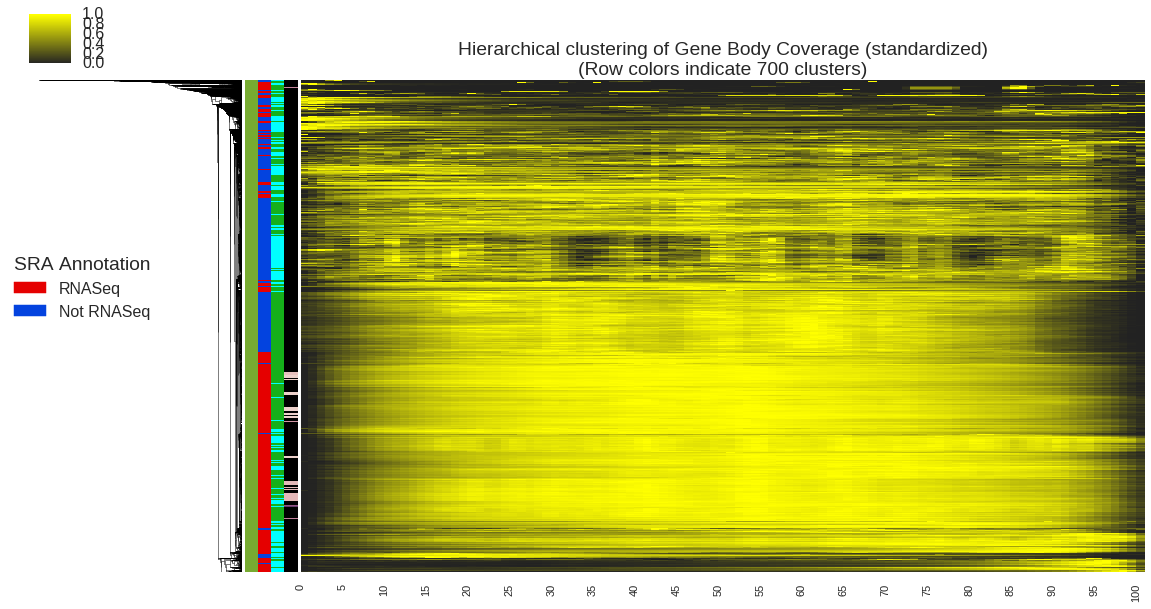

In [41]:
# Draw Heatmap
clust = sns.clustermap(gb_cov, 
               row_linkage=row_linkage, 
               col_cluster=False, 
               yticklabels=False,
               standard_scale=0,
               cmap=sns.dark_palette('yellow', as_cmap=True),
               row_colors=colors,
               figsize=(20, 10)
              )
clust.ax_heatmap.set_title('Hierarchical clustering of Gene Body Coverage (standardized)\n(Row colors indicate 700 clusters)')
clust.ax_heatmap.xaxis.set_ticks(range(0, 101, 5))
clust.ax_heatmap.xaxis.set_ticklabels(range(0, 101, 5), fontsize=11)
clust.ax_row_colors.xaxis.set_visible(False)
hr = mpl.patches.Patch(color=r)
hb = mpl.patches.Patch(color=b)
clust.ax_row_dendrogram.legend([hr, hb], ['RNASeq', 'Not RNASeq'], title="SRA Annotation", loc=(-0.1, .5), bbox_transform=clust.ax_row_dendrogram.transAxes);

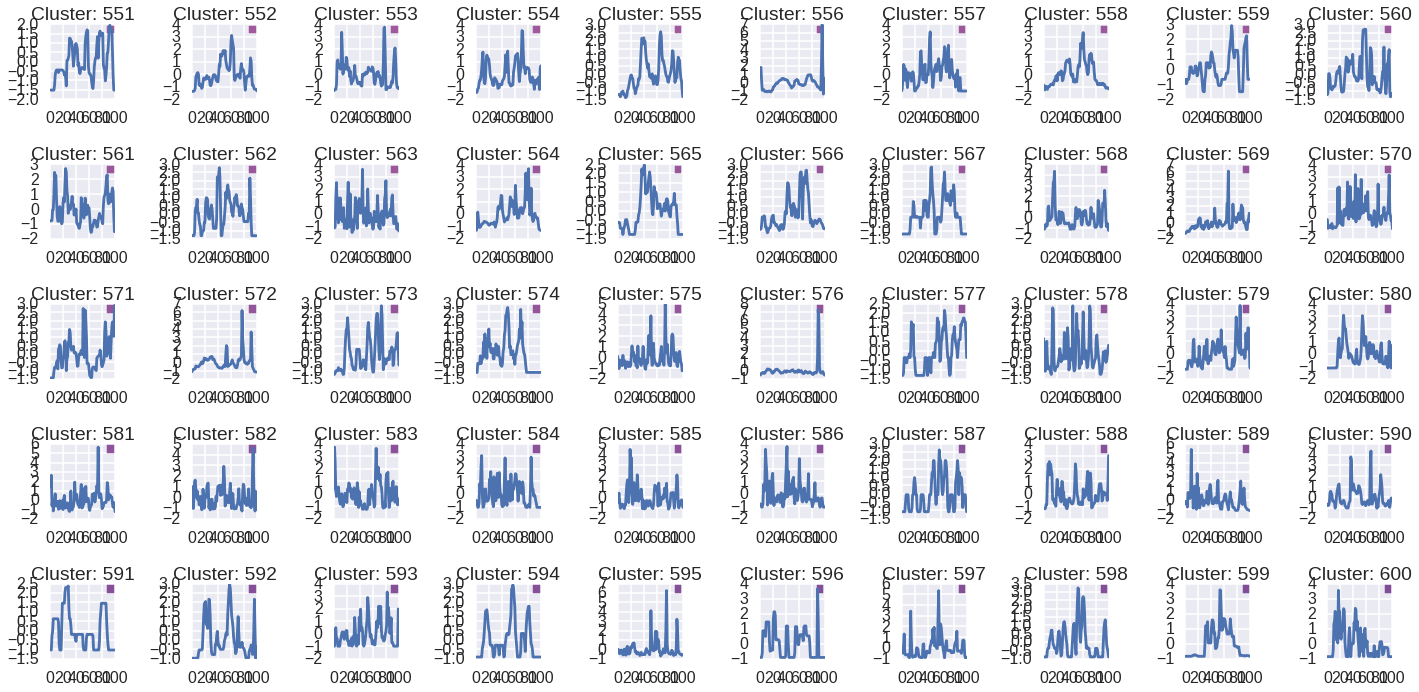

In [79]:
# Plot density graphs of coverage by cluster
norm = gb_cov.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = np.ravel(axes)
for g, d in clustDf.reset_index().groupby('cluster'):
    if 550 < g < 601:
        ax = axes[g-551]
        ax.add_patch(plt.Rectangle((.88,.88), .1, .1, color=mapper[g], transform=ax.transAxes))
        norm.loc[d['index']].T.plot(legend=False, ax=ax, title='Cluster: {}'.format(g))
plt.tight_layout()